In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import math

# Load dataset and basic process

Duration of original dataset range from 9,627 to 9,770 seconds. After basic pre-process, data before 460 seconds or after 9600 seconds are eliminated, in order to delete imperfect data and make the duration of all variables consistent.

Motionless_time timestamps, from 2 second before which to 2 second after which the vehicle remain motionless, are extracted from 'Backbone1J1939-1.45.0::HRW_X_EBS::FrontAxleRightWheelSpeed[Km_per_h]'

By observing the curve of the variables, 28 variables are selected that are worthy of further study.

Hyperparams: 

    start_point=460
    
    end_point=9600
    
    last_time=200
    
    columns_position=[0,4,5,6,7,8,9,10,12,13,22,23,24,25,26,29,30,31,32,33,38]
    
    vehicle_weight=8932.3
    
    full_load=24000
    
    steer_transformation=18.6

In [2]:
# load dataset collected from vehicle

#original_data=pd.read_csv("original_dataset/test_data_full_1.csv",header=0, sep=';')
original_data=pd.read_csv("data/01_original_dataset/test_data_minimal_1.csv",header=0, sep=';')
driveline_engaged=pd.read_csv("data/01_original_dataset/TransmissionDrivelineEngaged.csv",header=0, sep=';')
driveline_engaged.rename(columns={'Time[s]': 'time38'}, inplace=True)
combination_data=pd.concat([original_data,driveline_engaged],axis=1)

C:\Users\a419399\Anaconda3\envs\venv1\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (0,3,4,6,7,9,10,12,15,16,18,19,21,22,24,25,27,28,30,31,33,34,36,37,39,40,42,45,46,48,49,51,52,54,55,57,58,60,61,63,64,66,67,69,70,72,73,75,76,78,79,81,84,87,88,90,91,93,94,96,97,99,100,102,103,108,109,111,112) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Basic Pre-process

# Delete empty columns
data1=combination_data.dropna(axis=1,how='all')

# Replace ',' in numbers with '.'
data2=data1.replace(to_replace=r',', value='.',regex=True)

# Change type of data to numeric
data3=data2.astype(float) 
display(data3)

Time[s]  \
0        0.319003   
1        2.319155   
2        4.319156   
3        6.319267   
4        8.319398   
...           ...   
1425271       NaN   
1425272       NaN   
1425273       NaN   
1425274       NaN   
1425275       NaN   

         Backbone1J1939-1.45.0::CVW_X_EBS::GrossCombinationVehicleWeight[kg]  \
0                                                 655350.0                     
1                                                 655350.0                     
2                                                 655350.0                     
3                                                 655350.0                     
4                                                 655350.0                     
...                                                    ...                     
1425271                                                NaN                     
1425272                                                NaN                     
1425273                                                NaN                     
1425274                                                NaN                     
1425275                                                NaN                     

         Time[s].1  \
0         0.008791   
1         0.048233   
2         0.088216   
3         0.128219   
4         0.168212   
...            ...   
1425271        NaN   
1425272        NaN   
1425273        NaN   
1425274        NaN   
1425275        NaN   

         Backbone1J1939-1.45.0::EBS_BB1_02P::LongitudinalAcceleration[m_per_s_squared]  \
0                                                 0.000012                               
1                                                 0.000012                               
2                                                 0.000012                               
3                                                 0.000012                               
4                                                 0.000012                               
...                                                    ...                               
1425271                                                NaN                               
1425272                                                NaN                               
1425273                                                NaN                               
1425274                                                NaN                               
1425275                                                NaN                               

         Time[s].2  \
0         0.079712   
1         0.180234   
2         0.279628   
3         0.379580   
4         0.480267   
...            ...   
1425271        NaN   
1425272        NaN   
1425273        NaN   
1425274        NaN   
1425275        NaN   

         Backbone1J1939-1.45.0::EBS_BB1_05P::Trailer1AxleLoad_AxleLoad[kg]  \
0                                                   3600.0                   
1                                                   3600.0                   
2                                                   3600.0                   
3                                                   3600.0                   
4                                                   3600.0                   
...                                                    ...                   
1425271                                                NaN                   
1425272                                                NaN                   
1425273                                                NaN                   
1425274                                                NaN                   
1425275                                                NaN                   

         Time[s].3  Backbone1J1939-1.45.0::EEC1_X_EMS::EngineSpeed[rpm]  \
0         0.000737                                            753.750     
1         0.020735                                            753.750     
2         0.040740     

In [4]:
# basic analysis

variables_character_index=['start_time','end_time','duration','period','period_std','mean','variance','isconst']
variables_character_columns=data3.columns[1::2]
variables_character=pd.DataFrame(index=variables_character_index,columns=variables_character_columns)
variables_character.at['isconst']=False

for i in range(0,len(variables_character_columns)):
    temp_col=data3.iloc[:,i*2:i*2+2].dropna(axis=0)
    
    #character regarding colllecting period
    temp_period=temp_col.iloc[1:,0].reset_index().sub(temp_col.iloc[:-1,0].reset_index(),axis=0).drop(columns=['index'])
    variables_character.at['start_time',variables_character_columns[i]]=temp_col.iloc[0,0]
    variables_character.at['end_time',variables_character_columns[i]]=temp_col.iloc[-1,0]
    variables_character.at['duration',variables_character_columns[i]]=temp_col.iloc[-1,0]-temp_col.iloc[0,0]
    variables_character.at['period',variables_character_columns[i]]=temp_period.mean()[0]
    variables_character.at['period_std',variables_character_columns[i]]=temp_period.std()[0]
    if temp_period.std()[0]>temp_period.mean()[0]*0.2:
        print('check missing period for'+str(variables_character_columns[i]))
    
    # character regarding variable
    variables_character.at['mean',variables_character_columns[i]]=temp_col.mean()[1]
    variables_character.at['variance',variables_character_columns[i]]=temp_col.std()[1]
    if temp_col.std()[1]<0.01:
        variables_character.at['isconst',variables_character_columns[i]]=True
        print(str(variables_character_columns[i])+'seems being const')

display(variables_character.iloc[:,:])



Backbone2-1.45.0::HMIIOM_BB2_11P::VehicleCalibratedLoad[kg]seems being const
Backbone2-1.45.0::VMCU_BB2_18P::RelativeLevelRearAxleRight[mm]seems being const
Backbone2-1.45.0::VMCU_BB2_18P::RelativeLevelFrontAxleRight[mm]seems being const
Backbone2-1.45.0::VMCU_BB2_18P::RelativeLevelFrontAxleLeft[mm]seems being const
VANCANB::CombinationStructure0::VehicleMassStatus[kg]seems being const
check missing period forVANCANB::VehicleMotionSts0::RearAxleCurvatureStatus[1_per_m]
VANCANB::VehicleMotionSts6_Axle::FrontAxleLoadStatus[kg]seems being const


Backbone1J1939-1.45.0::CVW_X_EBS::GrossCombinationVehicleWeight[kg]  \
start_time                                           0.319003                    
end_time                                          9771.679332                    
duration                                          9771.360329                    
period                                               1.999869                    
period_std                                           0.000443                    
mean                                             51685.696746                    
variance                                        130455.085414                    
isconst                                                 False                    

           Backbone1J1939-1.45.0::EBS_BB1_02P::LongitudinalAcceleration[m_per_s_squared]  \
start_time                                           0.008791                              
end_time                                           9771.92885                              
duration                                          9771.920059                              
period                                               0.039997                              
period_std                                           0.000681                              
mean                                                  0.00007                              
variance                                             0.376022                              
isconst                                                 False                              

           Backbone1J1939-1.45.0::EBS_BB1_05P::Trailer1AxleLoad_AxleLoad[kg]  \
start_time                                           0.079712                  
end_time                                          9771.841044                  
duration                                          9771.761332                  
period                                               0.099993                  
period_std                                           0.000603                  
mean                                              3602.539294                  
variance                                           310.661067                  
isconst                                                 False                  

           Backbone1J1939-1.45.0::EEC1_X_EMS::EngineSpeed[rpm]  \
start_time                                           0.000737    
end_time                                          9771.928278    
duration                                          9771.927541    
period                                                   0.02    
period_std                                            0.00024    
mean                                               923.204457    
variance                                           189.391096    
isconst                                                 False    

           Backbone1J1939-1.45.0::EEC1_X_EMS::ActualEnginePercentTorque[Percent]  \
start_time                                           0.000737                      
end_time                                          9771.928278                      
duration                                          9771.927541                      
period                                                   0.02                      
period_std                                            0.00024                      
mean                                                17.841785                      
variance                                            20.272887                      
isconst                                                 False                      

           Backbone1J1939-1.45.0::HRW_X_EBS::FrontAxleRightWheelSpeed[Km_per_h]  \
start_time                                           0.017836                     
end_time                                           9771.91758                     
duration                                          9771.899744                     
period                                

In [5]:
# drop data out of [460s-9600s)

start_point=460
end_point=9600
data4=data3.copy(deep=True)

for i in range(0,int(len(data3.columns)/2)):
    data4.iloc[:int(round(start_point/variables_character.at['period',data3.columns[i*2+1]])),i*2:i*2+2]=np.nan
    data4.iloc[int(round(end_point/variables_character.at['period',data3.columns[i*2+1]])):,i*2:i*2+2]=np.nan
display(data4)

Time[s]  \
0            NaN   
1            NaN   
2            NaN   
3            NaN   
4            NaN   
...          ...   
1425271      NaN   
1425272      NaN   
1425273      NaN   
1425274      NaN   
1425275      NaN   

         Backbone1J1939-1.45.0::CVW_X_EBS::GrossCombinationVehicleWeight[kg]  \
0                                                      NaN                     
1                                                      NaN                     
2                                                      NaN                     
3                                                      NaN                     
4                                                      NaN                     
...                                                    ...                     
1425271                                                NaN                     
1425272                                                NaN                     
1425273                                                NaN                     
1425274                                                NaN                     
1425275                                                NaN                     

         Time[s].1  \
0              NaN   
1              NaN   
2              NaN   
3              NaN   
4              NaN   
...            ...   
1425271        NaN   
1425272        NaN   
1425273        NaN   
1425274        NaN   
1425275        NaN   

         Backbone1J1939-1.45.0::EBS_BB1_02P::LongitudinalAcceleration[m_per_s_squared]  \
0                                                      NaN                               
1                                                      NaN                               
2                                                      NaN                               
3                                                      NaN                               
4                                                      NaN                               
...                                                    ...                               
1425271                                                NaN                               
1425272                                                NaN                               
1425273                                                NaN                               
1425274                                                NaN                               
1425275                                                NaN                               

         Time[s].2  \
0              NaN   
1              NaN   
2              NaN   
3              NaN   
4              NaN   
...            ...   
1425271        NaN   
1425272        NaN   
1425273        NaN   
1425274        NaN   
1425275        NaN   

         Backbone1J1939-1.45.0::EBS_BB1_05P::Trailer1AxleLoad_AxleLoad[kg]  \
0                                                      NaN                   
1                                                      NaN                   
2                                                      NaN                   
3                                                      NaN                   
4                                                      NaN                   
...                                                    ...                   
1425271                                                NaN                   
1425272                                                NaN                   
1425273                                                NaN                   
1425274                                                NaN                   
1425275                                                NaN                   

         Time[s].3  Backbone1J1939-1.45.0::EEC1_X_EMS::EngineSpeed[rpm]  \
0              NaN                                                NaN     
1              NaN                                                NaN     
2              NaN                

In [7]:
# motionless status
FRWS=data4.loc[:,'Backbone1J1939-1.45.0::HRW_X_EBS::FrontAxleRightWheelSpeed[Km_per_h]'].dropna(axis=0)
last_time=200
zero_count=pd.DataFrame(index=range(len(FRWS)))
# row index of zero_count range from 0 to len(FRWS). 
# df.at[100,0] refer to the name of index and colomn so it could be the any row that named as 100, while df.iloc[] refers to actual position

for i in range(len(FRWS)):
    zero_count.at[i,0]=np.sum(FRWS.iloc[max(0,int(i-last_time/2)):min(int(i+last_time/2),len(FRWS))]<= 0.001)
motionless_time=np.where(zero_count==last_time)[0]


# here the motionless_time represent the timestamp after cutting 0-460 and 9600-end. 
# e.g. timestamp 100 is motionless, it correspond to 100/samplingfrequency of FRWS (50) +460, i.e. 462 second in the original dataset.

In [8]:
print(len(motionless_time))
motionless_time_dense=sorted(list(motionless_time)+[i+0.5 for i in motionless_time])
''' since sampling frequency of wheel speed is 50Hz while the maximal sampling frequency among all variables is 100Hz, 
to avoid waste of data when extracting motionless period for those high sampling frequency variables,
motionless_time_dense designed to present same periods as motionless_time with more concrete timestamps'''
print(len(motionless_time_dense))

42242
84484


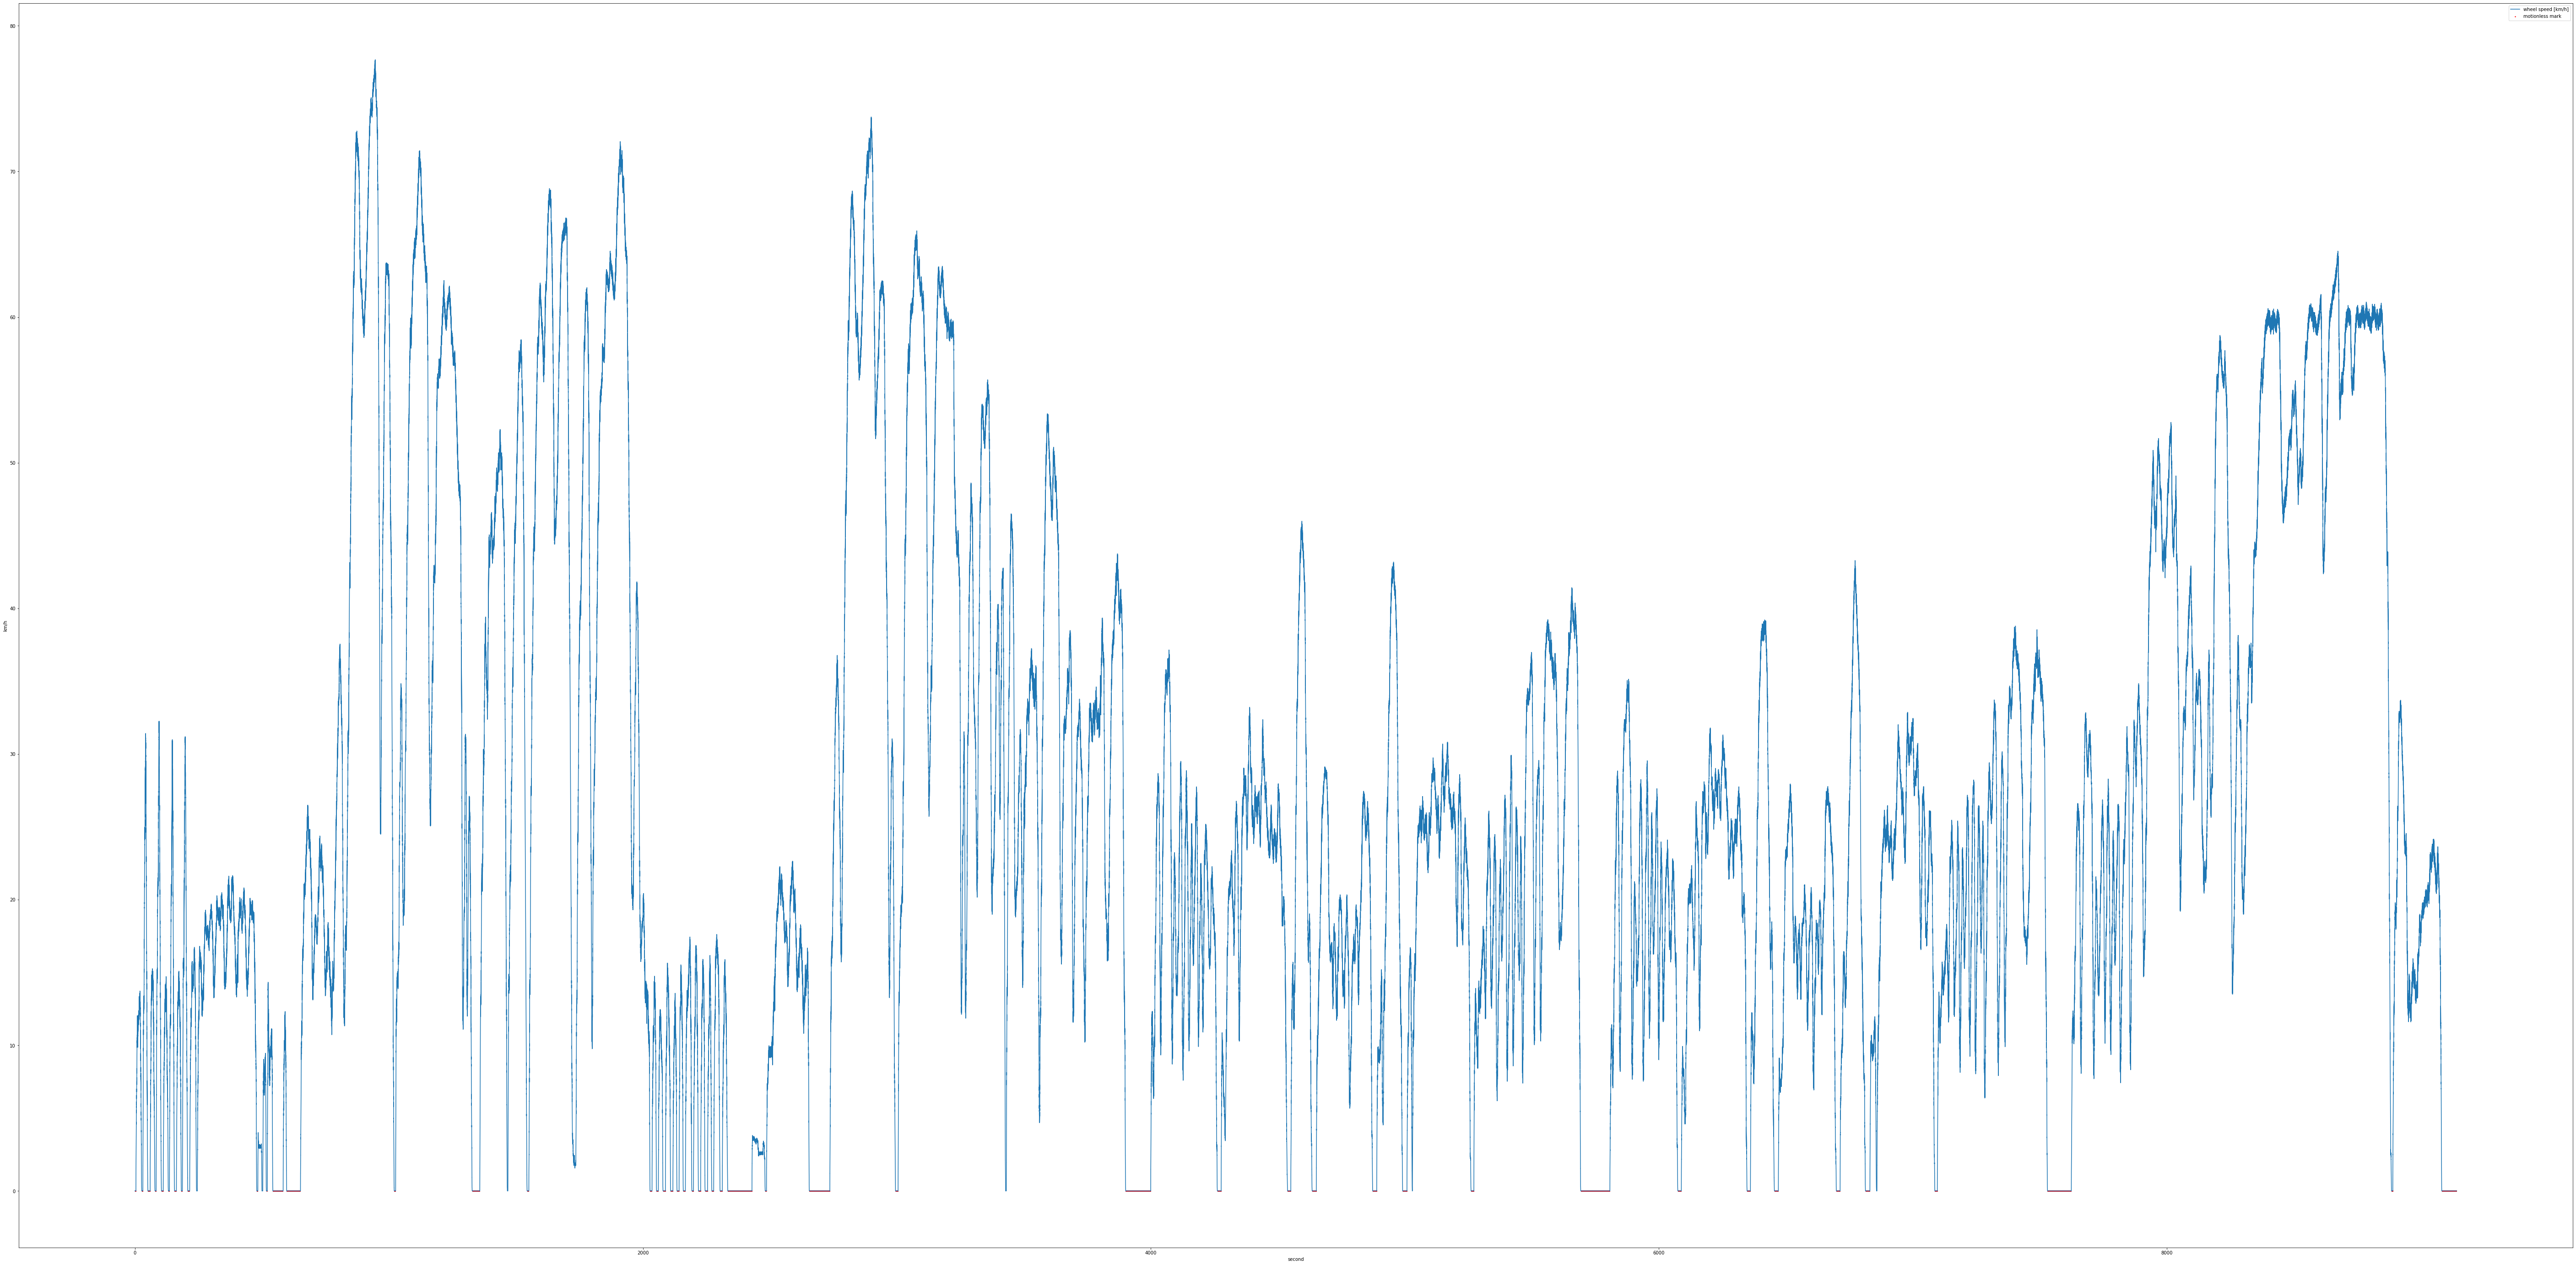

In [9]:
plt.figure(figsize=(100,50))
l=len(data4.loc[:,'Backbone1J1939-1.45.0::HRW_X_EBS::FrontAxleRightWheelSpeed[Km_per_h]'].dropna(axis=0))
plt.plot(np.linspace(0,(l-1)/50,l),data4.loc[:,'Backbone1J1939-1.45.0::HRW_X_EBS::FrontAxleRightWheelSpeed[Km_per_h]'].dropna(axis=0), label='wheel speed [km/h]')
plt.scatter(motionless_time/50,np.zeros((len(motionless_time))),color='red',s=2,label='motionless mark')
plt.legend()
plt.xlabel('second')
plt.ylabel('km/h')
plt.savefig('motionless.png')

In [10]:
# columns_position tells the position of desired variables among the whole dataset, need to be manually set
# only run once
vehicle_weight=8932.3
full_load=24000
columns_position=[0,5,6,7,8,10,12,13,22,23,24,25,26,29,30,31,32,33,38]


columns=data3.columns[1::2][columns_position]
data5=data4.iloc[:,sorted([i*2 for i in columns_position]+[i*2+1 for i in columns_position])]
data5.loc[:,'Backbone1J1939-1.45.0::CVW_X_EBS::GrossCombinationVehicleWeight[kg]']=data5.loc[:,'Backbone1J1939-1.45.0::CVW_X_EBS::GrossCombinationVehicleWeight[kg]'].apply(lambda x: (x-vehicle_weight)/full_load)
display(data5.iloc[46000:,:])

C:\Users\a419399\Anaconda3\envs\venv1\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


Time[s]  \
46000        NaN   
46001        NaN   
46002        NaN   
46003        NaN   
46004        NaN   
...          ...   
1425271      NaN   
1425272      NaN   
1425273      NaN   
1425274      NaN   
1425275      NaN   

         Backbone1J1939-1.45.0::CVW_X_EBS::GrossCombinationVehicleWeight[kg]  \
46000                                                  NaN                     
46001                                                  NaN                     
46002                                                  NaN                     
46003                                                  NaN                     
46004                                                  NaN                     
...                                                    ...                     
1425271                                                NaN                     
1425272                                                NaN                     
1425273                                                NaN                     
1425274                                                NaN                     
1425275                                                NaN                     

          Time[s].5  \
46000    919.959040   
46001    919.979112   
46002    919.998679   
46003    920.019094   
46004    920.038651   
...             ...   
1425271         NaN   
1425272         NaN   
1425273         NaN   
1425274         NaN   
1425275         NaN   

         Backbone1J1939-1.45.0::HRW_X_EBS::FrontAxleRightWheelSpeed[Km_per_h]  \
46000                                            19.222656                      
46001                                            19.230469                      
46002                                            18.765625                      
46003                                            19.214844                      
46004                                            19.199219                      
...                                                    ...                      
1425271                                                NaN                      
1425272                                                NaN                      
1425273                                                NaN                      
1425274                                                NaN                      
1425275                                                NaN                      

          Time[s].6  \
46000    919.959040   
46001    919.979112   
46002    919.998679   
46003    920.019094   
46004    920.038651   
...             ...   
1425271         NaN   
1425272         NaN   
1425273         NaN   
1425274         NaN   
1425275         NaN   

         Backbone1J1939-1.45.0::HRW_X_EBS::RearAxleLeftWheelSpeed[Km_per_h]  \
46000                                            17.113281                    
46001                                            17.062500                    
46002                                            17.035156                    
46003                                            17.035156                    
46004                                            17.062500                    
...                                                    ...                    
1425271                                                NaN                    
1425272                                                NaN                    
1425273                                                NaN                    
1425274                                                NaN                    
1425275                                                NaN                    

          Time[s].7  \
46000    919.959040   
46001    919.979112   
46002    919.998679   
46003    920.019094   
46004    920.038651   
...             ...   
1425271         NaN   
1425272         NaN   
1425273         NaN   
1425274         NaN   
1425275         NaN   

         Backbone1J1939-1.45.0::HRW_X_EBS::RearAxleRig

# Frequency filter

With observation of frequency spectrum and motionless period data visualization, frequency filtering is implemented on 13 desired variables, containing 3 model inputs and 10 outputs. After finetune based on prior knowledge, cutoff frequency for input is 5Hz while for output is 10Hz. Besides, frequency filtering is not suitable for combination vehicle weight, since its sampling frequency (0.5) is too low for filter which could result in relatively huge gap between original data and filtered data.

Hyperparams:
    current_variables=16

In [12]:
desired_variables=19
current_variables=19

In [13]:
# frequency analysis

def getFrequencySpectrum(to_plot):
    # Frequency domain representation and normalization
    # normalize it by length of signal
    fourierTransform = np.fft.fft(to_plot.iloc[:,1])/len(to_plot.iloc[:,1])

    # frequency spectrum of real signal is symmetical due to nature of DFT, so keep only fist half 
    fourierTransform = fourierTransform[range(int(len(to_plot)/2))]

    # result represent the frequency spectrum over frequency interval [0, sampling frequency/2),
    # thus sampling frequency must be larger than the maximal signal frequency
    # np.fft.fft return list of length at len(signal), each item in the list represent amplitude corresponding to specific frequency,
    # so we map half of the result to interval [0, sampling frequency/2)
    samplingFrequency=1/variables_character.loc['period'][to_plot.columns[-1]]
    frequencies=np.linspace(0,samplingFrequency/2,int(len(to_plot)/2))
    
    return frequencies,abs(fourierTransform)

"\nfig, ax = plt.subplots(desired_variables,2,figsize=(60,200))\n\nfor i in range(int(len(data5.columns)/2)):\n    \n    to_plot=data5.iloc[:,i*2:i*2+2].dropna(axis=0)\n    x,y=getFrequencySpectrum(to_plot)\n    ax[i][0].plot(to_plot.iloc[:,0],to_plot.iloc[:,1])\n    ax[i][1].plot(x,y)\n    ax[i][0].set_title(to_plot.columns[1],fontsize=20)\n    ax[i][0].tick_params(axis='x', labelsize=20)\n    ax[i][0].tick_params(axis='y', labelsize=20)\n    ax[i][1].tick_params(axis='x', labelsize=20)\n    ax[i][1].tick_params(axis='y', labelsize=20)\n#plt.savefig('plots/signal1.png')\n"

In [15]:
# frequency property

index=['motionless_value_mean','motionless_value_std','maximal_frequency','minmal_frequency','sampling_frequency','order','filter_type']
columns=data5.columns[1::2]
frequency_property=pd.DataFrame(index=index,columns=columns)

FRWS_period=variables_character.at['period','Backbone1J1939-1.45.0::HRW_X_EBS::FrontAxleRightWheelSpeed[Km_per_h]']
for i in range(len(columns)):
    period=variables_character.at['period',data5.columns[i*2+1]]
    if period>=FRWS_period:
        temp_variable=data5.iloc[:,i*2:i*2+2].dropna().iloc[sorted(list(set((motionless_time/period*FRWS_period).round(0).astype(int)))),:]
    else:
        temp_variable=data5.iloc[:,i*2:i*2+2].dropna().iloc[sorted(list(set((motionless_time_dense/period*FRWS_period).round(0).astype(int)))),:]
    #vals,counts=np.unique(temp_variable, return_counts=True)
    #print(vals[np.argmax(counts)],counts[np.argmax(counts)])
    frequency_property.loc['motionless_value_mean',data5.columns[i*2+1]]=np.mean(temp_variable.iloc[:,-1])
    frequency_property.loc['motionless_value_std',data5.columns[i*2+1]]=np.std(temp_variable.iloc[:,-1])
    frequency_property.loc['sampling_frequency',data5.columns[i*2+1]]=1/variables_character.at['period',data5.columns[i*2+1]]
frequency_property.loc['filter_type']='lowpass'

display(frequency_property)

Backbone1J1939-1.45.0::CVW_X_EBS::GrossCombinationVehicleWeight[kg]  \
motionless_value_mean                                           0.603109                    
motionless_value_std                                            0.037046                    
maximal_frequency                                                    NaN                    
minmal_frequency                                                     NaN                    
sampling_frequency                                              0.500033                    
order                                                                NaN                    
filter_type                                                      lowpass                    

                      Backbone1J1939-1.45.0::HRW_X_EBS::FrontAxleRightWheelSpeed[Km_per_h]  \
motionless_value_mean                                                0.0                     
motionless_value_std                                                 0.0                     
maximal_frequency                                                    NaN                     
minmal_frequency                                                     NaN                     
sampling_frequency                                             50.003277                     
order                                                                NaN                     
filter_type                                                      lowpass                     

                      Backbone1J1939-1.45.0::HRW_X_EBS::RearAxleLeftWheelSpeed[Km_per_h]  \
motionless_value_mean                                                0.0                   
motionless_value_std                                                 0.0                   
maximal_frequency                                                    NaN                   
minmal_frequency                                                     NaN                   
sampling_frequency                                             50.003277                   
order                                                                NaN                   
filter_type                                                      lowpass                   

                      Backbone1J1939-1.45.0::HRW_X_EBS::RearAxleRightWheelSpeed[Km_per_h]  \
motionless_value_mean                                                0.0                    
motionless_value_std                                                 0.0                    
maximal_frequency                                                    NaN                    
minmal_frequency                                                     NaN                    
sampling_frequency                                             50.003277                    
order                                                                NaN                    
filter_type                                                      lowpass                    

                      Backbone1J1939-1.45.0::HRW_X_EBS::FrontAxleLeftWheelSpeed[Km_per_h]  \
motionless_value_mean                                                0.0                    
motionless_value_std                                                 0.0                    
maximal_frequency                                                    NaN                    
minmal_frequency                                                     NaN                    
sampling_frequency                                             50.003277                    
order                                                                NaN                    
filter_type                                                      lowpass                    

                      Backbone1J1939-1.45.0::VDC2_X_EBS::SteeringWheelAngle[rad]  \
motionless_value_mean                                           0.430199           
motionless_value_std                                            0.742647           
maximal_frequency                            

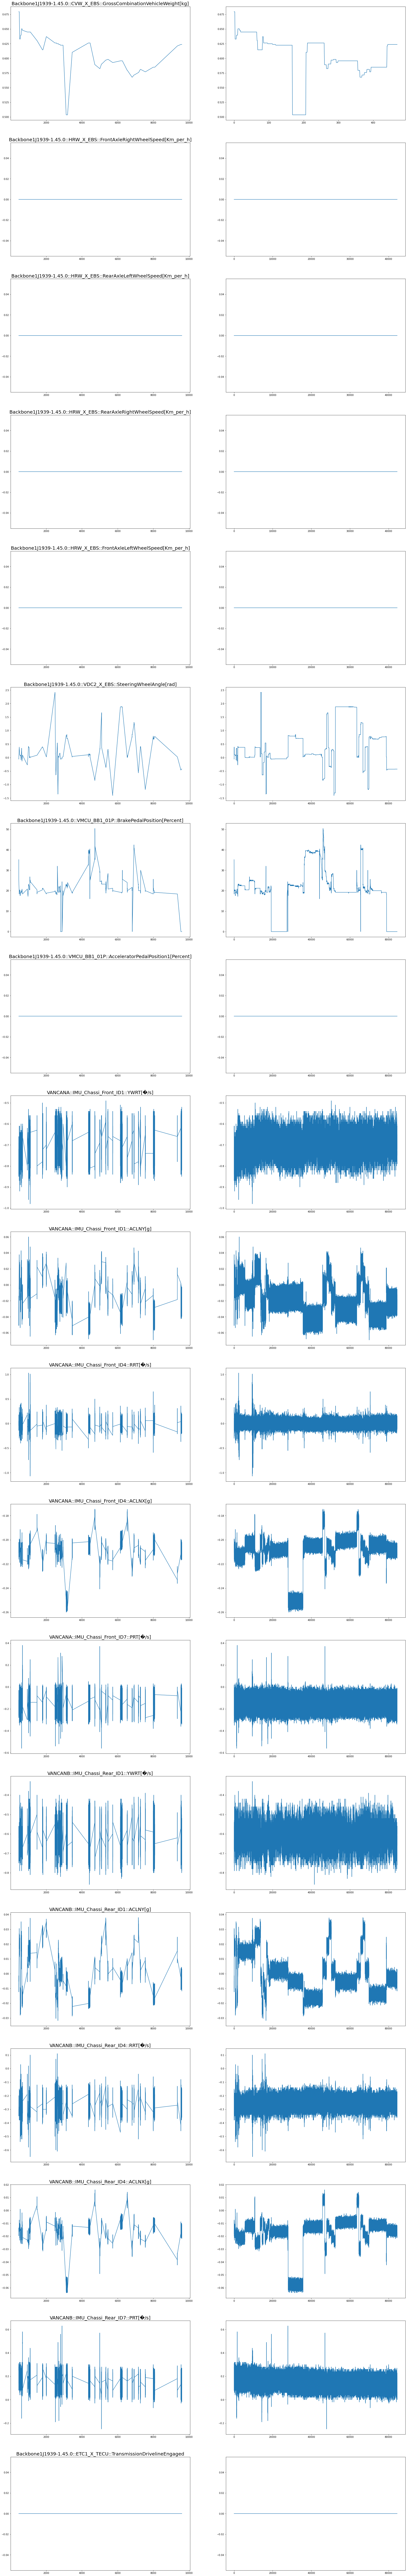

In [16]:
# motionless period data visualization
# these plots in conjunction with table above assist designing the filter
fig, ax = plt.subplots(current_variables,2,figsize=(30,200))

columns=data5.columns[1::2]
for i in range(len(columns)):
    period=variables_character.at['period',data5.columns[i*2+1]]
    if period>=FRWS_period:
        temp_variable=data5.iloc[:,i*2:i*2+2].dropna().iloc[sorted(list(set((motionless_time/period*FRWS_period).round(0).astype(int)))),:]
    else:
        temp_variable=data5.iloc[:,i*2:i*2+2].dropna().iloc[sorted(list(set((motionless_time_dense/period*FRWS_period).round(0).astype(int)))),:]
    
    ax[i][0].plot(temp_variable.iloc[:,0],temp_variable.iloc[:,1])
    ax[i][1].plot(range(len(temp_variable)),temp_variable.iloc[:,1])
    ax[i][0].set_title(data5.columns[i*2+1],fontsize=20)

    

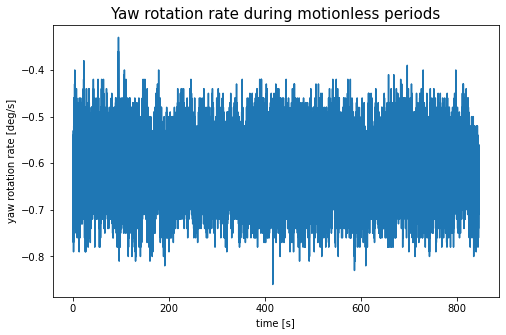

In [17]:
period=variables_character.at['period',data5.columns[27]]
if period>=FRWS_period:
    temp_variable=data5.iloc[:,26:28].dropna().iloc[sorted(list(set((motionless_time/period*FRWS_period).round(0).astype(int)))),:]
else:
    temp_variable=data5.iloc[:,26:28].dropna().iloc[sorted(list(set((motionless_time_dense/period*FRWS_period).round(0).astype(int)))),:]
plt.figure(figsize=(8,5))
plt.plot(np.linspace(0,(len(temp_variable)-1)/100,len(temp_variable)),temp_variable.iloc[:,1])
plt.title('Yaw rotation rate during motionless periods',fontsize=15)
plt.xlabel('time [s]',fontsize=10)
plt.ylabel('yaw rotation rate [deg/s]',fontsize=10)
plt.savefig('plots/ywrt_motionless.png')

Tips for determine frequency threshold:

    1. Butter filter has attenuation effect, so the cutoff vaue should contain larger interval to reduce the attenuation of expected frequency. To estimate attenuation: https://www.omnicalculator.com/physics/cutoff-frequency#what-is-cutoff-frequency-cutoff-frequency-definition
    
    2. The higher order of butter filter is, the higher attenuation rate is. https://www.researchgate.net/post/What_is_the_cutoff_frequency_for_filter_design_to_apply_to_vehicle_vibration_measured_using_accelerometer
    
    3. Steps to determine filter:
    
        a. Observe the motionless period data to determine the filter type. (band, low, or high)
        
        b. Define maximal frequency according to prior knowledge.
        
        c. Fine tune cutoff, select final filter parameter based on plots. (Criteria: not exceeding highest and lowest bound, maximal gap before and after filtering is small in some sense .
    

In [18]:
# denoising (frequency domain filter)

def butter_bandpass(lowcut, highcut, fs, order=5):
    return signal.butter(order, [lowcut, highcut], fs=fs, btype='bandpass')

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y


def butter_highpass(highcut, fs, order=5):
    return signal.butter(order, highcut, fs=fs, btype='highpass')

def butter_highpass_filtfilt(data,highcut, fs, order=5):
    b, a = butter_highpass(highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y


def butter_lowpass(lowcut, fs, order=5):
    return signal.butter(order, lowcut, fs=fs, btype='lowpass')

def butter_lowpass_filtfilt(data, lowcut, fs, order=5):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [19]:
# Denoise and Interpolate

temp_df=data5.copy(deep=True)

temp_df.iloc[:,0::2] =temp_df.iloc[:,0::2].apply(lambda x: round(x*100))
to_concatenate=pd.DataFrame(index=range(1000000))

gross_weight=temp_df.iloc[:,0:2].dropna()
gross_weight.drop_duplicates(subset=gross_weight.columns[0], keep='first',inplace=True)
gross_weight.iloc[:,0]=gross_weight.iloc[:,0].astype(int)
gross_weight.set_index(gross_weight.columns[0],inplace=True)
to_concatenate=pd.concat([to_concatenate,gross_weight],axis=1)

maximal_frequency=[np.nan,10,10,10,10,5,5,5,10,10,10,10,10,10,10,10,10,10]
bias=[np.nan,0,0,0,0,0,0,0,-0.698934,0,-0.004627,0,-0.144189,-0.60913,0,-0.257702,0,0.149287]
for i in range(1,current_variables-1):
    concatenating=temp_df.iloc[:,i*2:i*2+2].dropna()
    samplingFrequency=frequency_property.loc['sampling_frequency',concatenating.columns[-1]]
    concatenating.iloc[:,1]=butter_lowpass_filtfilt(concatenating.iloc[:,1],maximal_frequency[i],fs=samplingFrequency,order=9)-bias[i]
    concatenating.drop_duplicates(subset=concatenating.columns[0], keep='first',inplace=True)
    concatenating.iloc[:,0]=concatenating.iloc[:,0].astype(int)
    concatenating.set_index(concatenating.columns[0],inplace=True)
    to_concatenate=pd.concat([to_concatenate,concatenating],axis=1)

drivelineEngaged=temp_df.iloc[:,-2:].dropna()
drivelineEngaged.drop_duplicates(subset=drivelineEngaged.columns[0], keep='first',inplace=True)
drivelineEngaged.iloc[:,0]=drivelineEngaged.iloc[:,0].astype(int)
drivelineEngaged.set_index(drivelineEngaged.columns[0],inplace=True)
to_concatenate=pd.concat([to_concatenate,drivelineEngaged],axis=1)

to_concatenate=to_concatenate.iloc[start_point*100:end_point*100,:]
to_concatenate.interpolate(method='linear', axis=0,inplace=True)


#Input: load fraction, steering angle, brake pedal position, acceleration pedal position
# combination weight has been transformed to load fraction.
# Here steering angle is divided by 18.6, pedal position is scaled to 0-1

# Output: acceleration x and acceleration y, yaw, roll, and pitch rate in front and rear part of tractor.

steer_transformation=18.6

to_concatenate.loc[:,'Backbone1J1939-1.45.0::VDC2_X_EBS::SteeringWheelAngle[rad]']=to_concatenate.loc[:,'Backbone1J1939-1.45.0::VDC2_X_EBS::SteeringWheelAngle[rad]'].apply(lambda x: x/steer_transformation)
to_concatenate.loc[:,'Backbone1J1939-1.45.0::VMCU_BB1_01P::BrakePedalPosition[Percent]']=to_concatenate.loc[:,'Backbone1J1939-1.45.0::VMCU_BB1_01P::BrakePedalPosition[Percent]'].apply(lambda x: x/100)
to_concatenate.loc[:,'Backbone1J1939-1.45.0::VMCU_BB1_01P::AcceleratorPedalPosition1[Percent]']=to_concatenate.loc[:,'Backbone1J1939-1.45.0::VMCU_BB1_01P::AcceleratorPedalPosition1[Percent]'].apply(lambda x: x/100)

display(to_concatenate)

Backbone1J1939-1.45.0::CVW_X_EBS::GrossCombinationVehicleWeight[kg]  \
46000                                                 NaN                     
46001                                                 NaN                     
46002                                                 NaN                     
46003                                                 NaN                     
46004                                                 NaN                     
...                                                   ...                     
959995                                           0.623654                     
959996                                           0.623654                     
959997                                           0.623654                     
959998                                           0.623654                     
959999                                           0.623654                     

        Backbone1J1939-1.45.0::HRW_X_EBS::FrontAxleRightWheelSpeed[Km_per_h]  \
46000                                                 NaN                      
46001                                                 NaN                      
46002                                                 NaN                      
46003                                       -3.979830e-18                      
46004                                       -1.770210e-17                      
...                                                   ...                      
959995                                     -3.135481e-216                      
959996                                     -4.393230e-216                      
959997                                     -5.650979e-216                      
959998                                     -3.201598e-216                      
959999                                     -7.522169e-217                      

        Backbone1J1939-1.45.0::HRW_X_EBS::RearAxleLeftWheelSpeed[Km_per_h]  \
46000                                                 NaN                    
46001                                                 NaN                    
46002                                                 NaN                    
46003                                        4.013289e-17                    
46004                                        1.648282e-17                    
...                                                   ...                    
959995                                     -3.181798e-216                    
959996                                     -4.512572e-216                    
959997                                     -5.843346e-216                    
959998                                     -3.332231e-216                    
959999                                     -8.211168e-217                    

        Backbone1J1939-1.45.0::HRW_X_EBS::RearAxleRightWheelSpeed[Km_per_h]  \
46000                                                 NaN                     
46001                                                 NaN                     
46002                                                 NaN                     
46003                                        2.815826e-17                     
46004                                        3.582006e-17                     
...                                                   ...                     
959995                                     -6.115596e-217                     
959996                                      1.588348e-216                     
959997                                      3.788255e-216                     
959998                                      3.118433e-216                     
959999                                      2.448610e-216                     

        Backbone1J1939-1.45.0::HRW_X_EBS::FrontAxleLeftWheelSpeed[Km_per_h]  \
46000                                                 NaN                     
46001                                                 

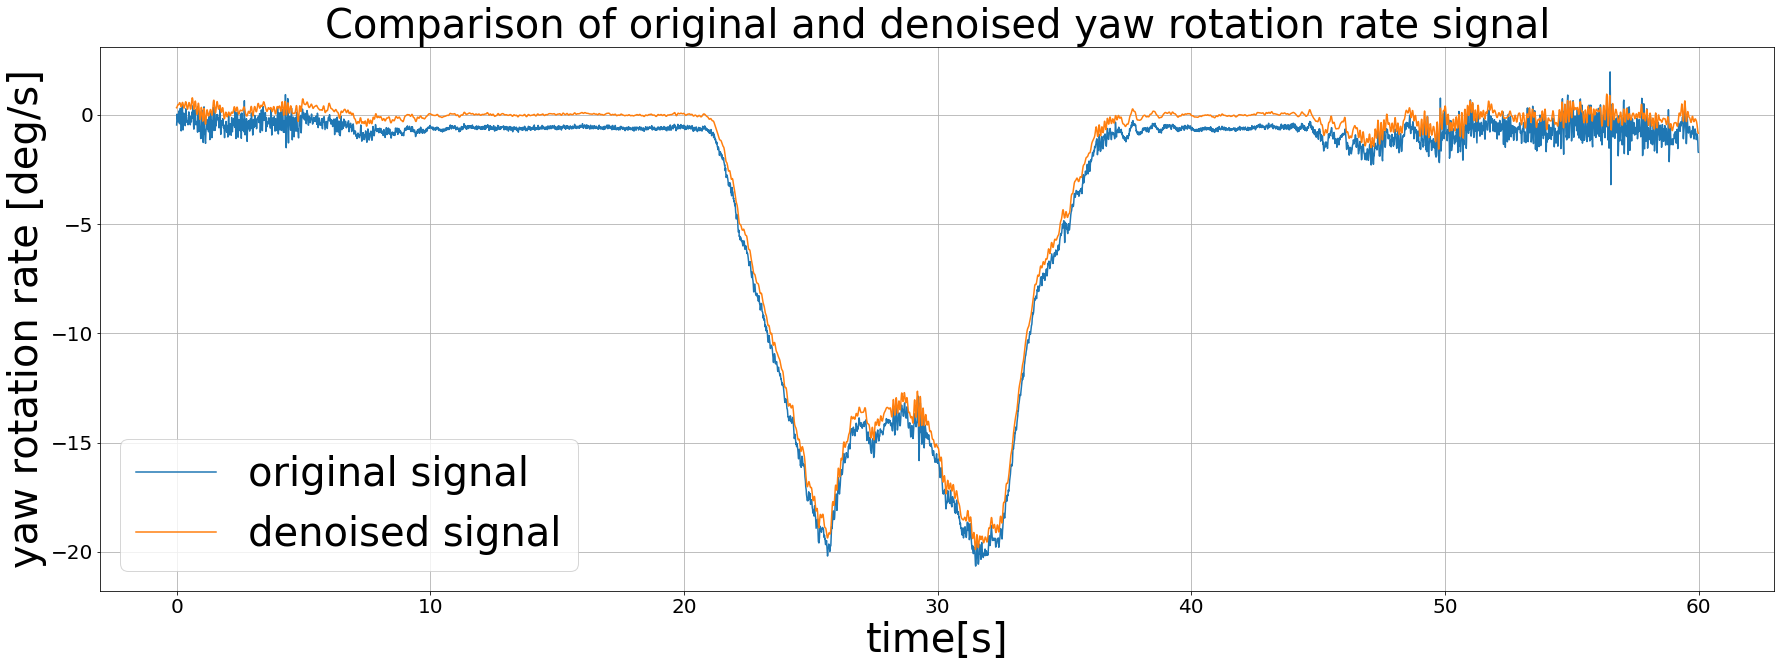

In [24]:
plt.figure(figsize=(30,10))
plt.plot(data5.iloc[50000:56000,26].dropna()-500,data5.iloc[50000:56000,27].dropna(),label='original signal')
plt.plot([i/100 for i in range(len(to_concatenate.iloc[4000:10000,13]))],to_concatenate.iloc[4000:10000,13],label='denoised signal')
plt.title('Comparison of original and denoised yaw rotation rate signal',fontsize=40)
plt.xlabel('time[s]',fontsize=40)
plt.ylabel('yaw rotation rate [deg/s]',fontsize=40)
plt.legend(prop={'size': 40})
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.grid()
plt.savefig('plots/yawsignal.png')

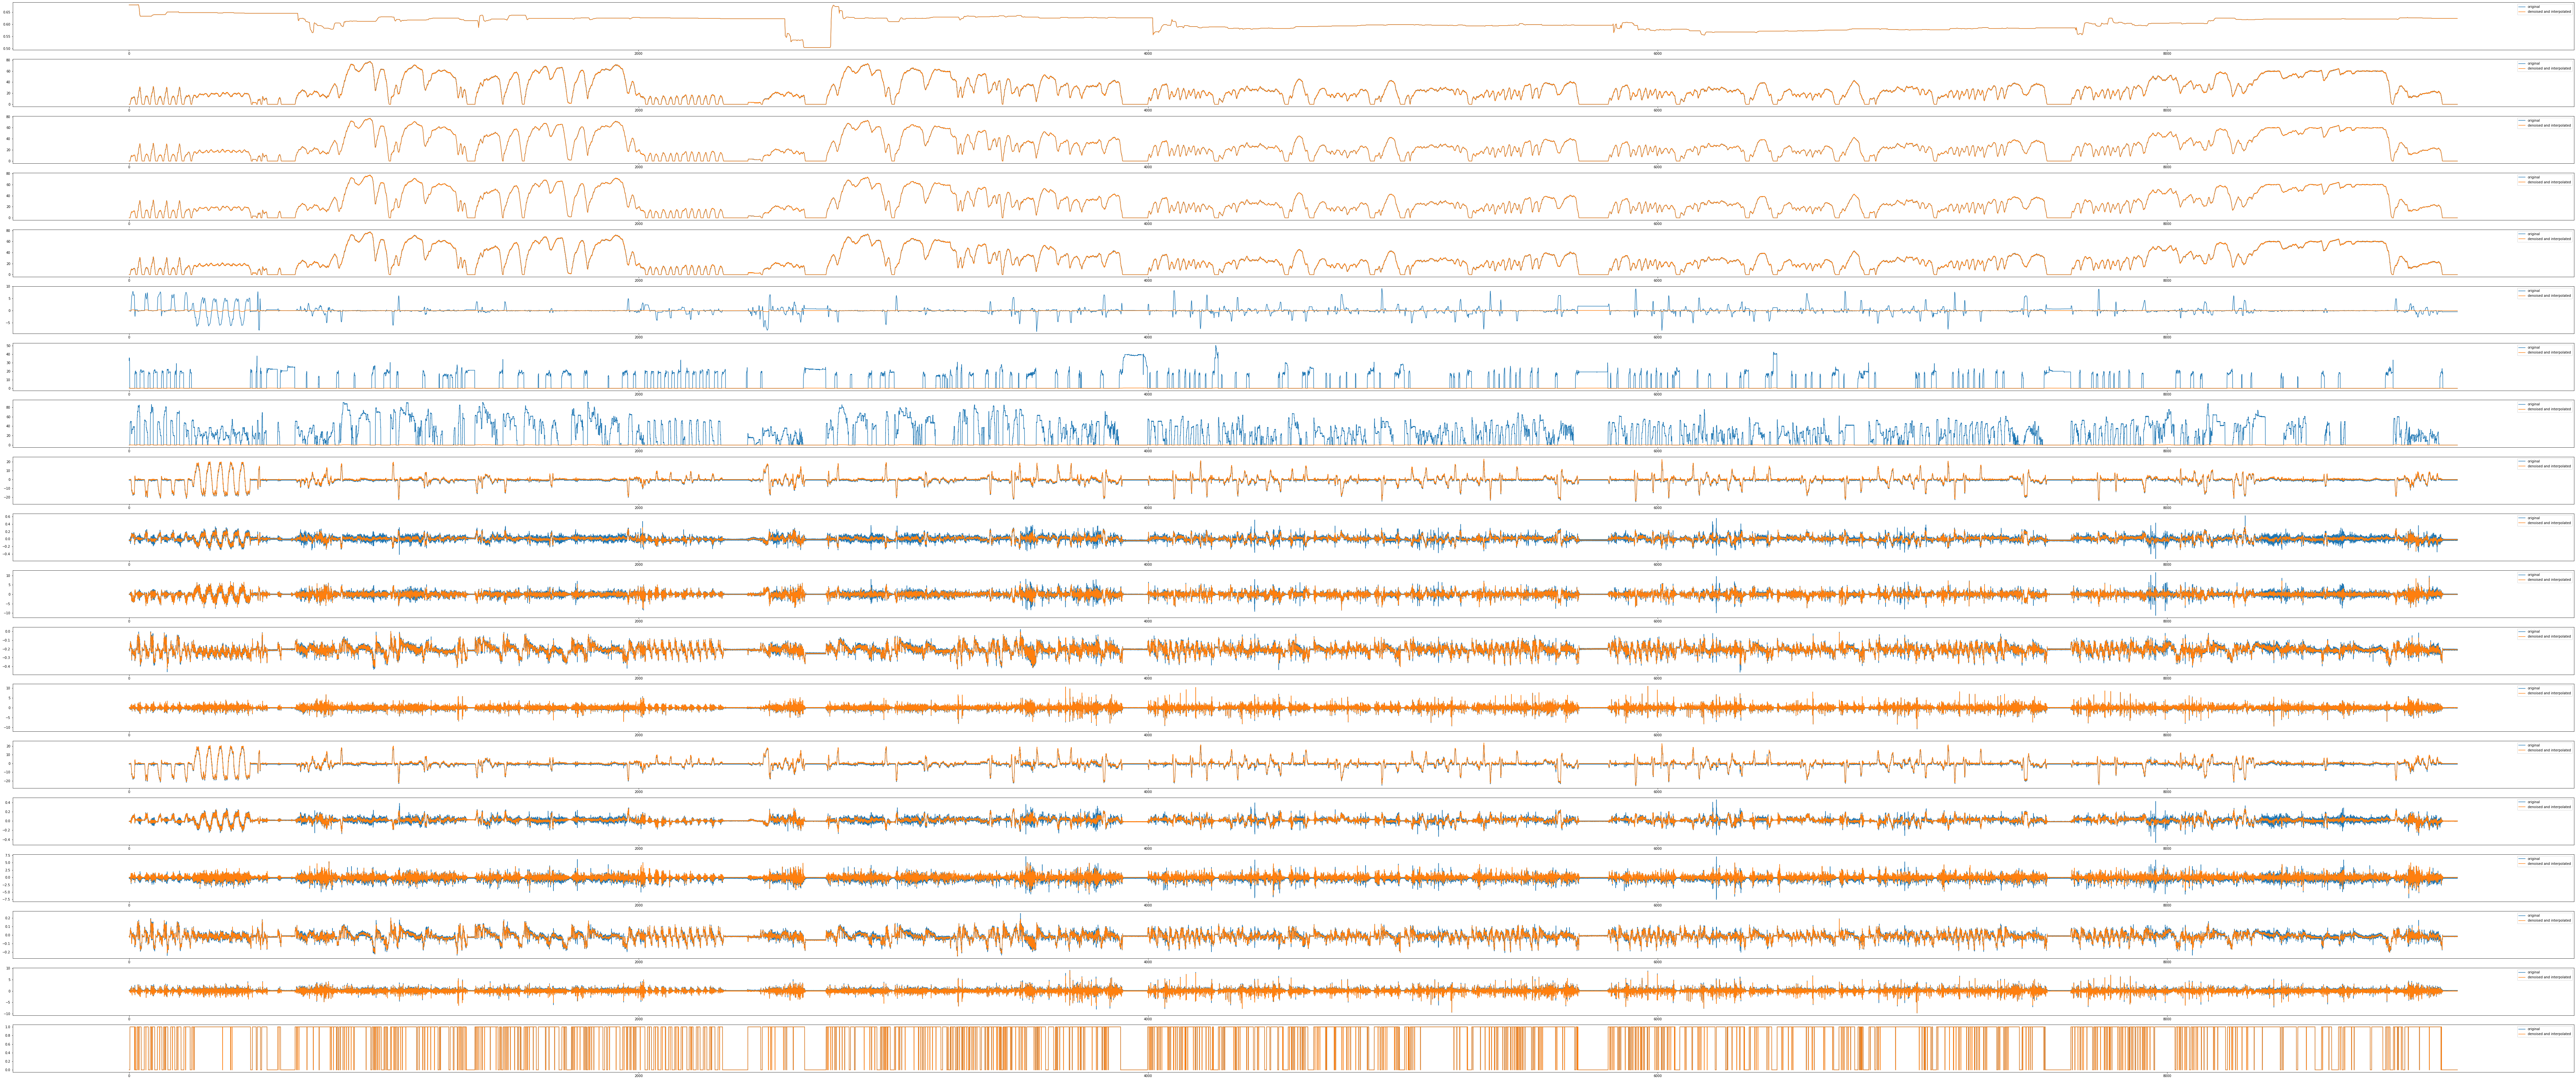

In [52]:
fig, ax = plt.subplots(current_variables,1,figsize=(140,60))
for i in range(current_variables):
    ax[i].plot(data5.iloc[:,i*2].dropna()-460,data5.iloc[:,i*2+1].dropna(),label='original')
    ax[i].plot([i/100 for i in range(len(to_concatenate.iloc[:,i]))],to_concatenate.iloc[:,i],label='denoised and interpolated')
    ax[i].legend()

In [23]:
# basic analysis

variables_character_index=['start_time','end_time','duration','period','period_std','mean','variance','isconst']
variables_character_columns=to_concatenate.columns
variables_character=pd.DataFrame(index=variables_character_index,columns=variables_character_columns)
variables_character.at['isconst']=False

for i in range(0,len(variables_character_columns)):
    temp_col=to_concatenate.iloc[:,i].dropna(axis=0)
    
    #character regarding colllecting period
    temp_period=temp_col.iloc[1:].reset_index().sub(temp_col.iloc[:-1].reset_index(),axis=0).drop(columns=['index'])
    variables_character.at['start_time',variables_character_columns[i]]=temp_col.iloc[0]
    variables_character.at['end_time',variables_character_columns[i]]=temp_col.iloc[-1]
    variables_character.at['duration',variables_character_columns[i]]=temp_col.iloc[-1]-temp_col.iloc[0]
    variables_character.at['period',variables_character_columns[i]]=temp_period.mean()[0]
    variables_character.at['period_std',variables_character_columns[i]]=temp_period.std()[0]
    if temp_period.std()[0]>temp_period.mean()[0]*0.2:
        print('check missing period for'+str(variables_character_columns[i]))
    
    # character regarding variable
    variables_character.at['mean',variables_character_columns[i]]=temp_col.mean()
    variables_character.at['variance',variables_character_columns[i]]=temp_col.std()
    if temp_col.std()<0.01:
        variables_character.at['isconst',variables_character_columns[i]]=True
        print(str(variables_character_columns[i])+'seems being const')

display(variables_character.iloc[:,:])

check missing period forBackbone1J1939-1.45.0::CVW_X_EBS::GrossCombinationVehicleWeight[kg]
check missing period forBackbone1J1939-1.45.0::HRW_X_EBS::FrontAxleRightWheelSpeed[Km_per_h]
check missing period forBackbone1J1939-1.45.0::HRW_X_EBS::RearAxleLeftWheelSpeed[Km_per_h]
check missing period forBackbone1J1939-1.45.0::HRW_X_EBS::RearAxleRightWheelSpeed[Km_per_h]
check missing period forBackbone1J1939-1.45.0::HRW_X_EBS::FrontAxleLeftWheelSpeed[Km_per_h]
check missing period forBackbone1J1939-1.45.0::VDC2_X_EBS::SteeringWheelAngle[rad]
check missing period forBackbone1J1939-1.45.0::VMCU_BB1_01P::BrakePedalPosition[Percent]
check missing period forBackbone1J1939-1.45.0::VMCU_BB1_01P::AcceleratorPedalPosition1[Percent]
check missing period forVANCANA::IMU_Chassi_Front_ID1::YWRT[�/s]
check missing period forVANCANA::IMU_Chassi_Front_ID1::ACLNY[g]
check missing period forVANCANA::IMU_Chassi_Front_ID4::RRT[�/s]
check missing period forVANCANA::IMU_Chassi_Front_ID4::ACLNX[g]
check missing p

Backbone1J1939-1.45.0::CVW_X_EBS::GrossCombinationVehicleWeight[kg]  \
start_time                                           0.679488                    
end_time                                             0.623654                    
duration                                            -0.055833                    
period                                                   -0.0                    
period_std                                           0.000015                    
mean                                                 0.606487                    
variance                                             0.025962                    
isconst                                                 False                    

           Backbone1J1939-1.45.0::HRW_X_EBS::FrontAxleRightWheelSpeed[Km_per_h]  \
start_time                                               -0.0                     
end_time                                                 -0.0                     
duration                                                  0.0                     
period                                                   -0.0                     
period_std                                           0.040018                     
mean                                                26.512494                     
variance                                            19.018164                     
isconst                                                 False                     

           Backbone1J1939-1.45.0::HRW_X_EBS::RearAxleLeftWheelSpeed[Km_per_h]  \
start_time                                                0.0                   
end_time                                                 -0.0                   
duration                                                 -0.0                   
period                                                    0.0                   
period_std                                           0.020383                   
mean                                                26.430063                   
variance                                            19.022103                   
isconst                                                 False                   

           Backbone1J1939-1.45.0::HRW_X_EBS::RearAxleRightWheelSpeed[Km_per_h]  \
start_time                                                0.0                    
end_time                                                  0.0                    
duration                                                 -0.0                    
period                                                    0.0                    
period_std                                           0.020878                    
mean                                                26.443525                    
variance                                            18.995608                    
isconst                                                 False                    

           Backbone1J1939-1.45.0::HRW_X_EBS::FrontAxleLeftWheelSpeed[Km_per_h]  \
start_time                                               -0.0                    
end_time                                                  0.0                    
duration                                                  0.0                    
period                                                   -0.0                    
period_std                                           0.038837                    
mean                                                26.498747                    
variance                                              19.0476                    
isconst                                                 False                    

           Backbone1J1939-1.45.0::VDC2_X_EBS::SteeringWheelAngle[rad]  \
start_time                                          -0.002624           
end_time                                            -0.022995           
duration                                            -0.020371           
period                  

# Save data

In [54]:
# uniform variables name
name_reset={}
name_reset['Backbone1J1939-1.45.0::HRW_X_EBS::FrontAxleRightWheelSpeed[Km_per_h]']='sensorFrontRightSpeed[Km_per_h]'
name_reset['Backbone1J1939-1.45.0::HRW_X_EBS::RearAxleLeftWheelSpeed[Km_per_h]']= 'sensorRearLeftSpeed[Km_per_h]'
name_reset['Backbone1J1939-1.45.0::HRW_X_EBS::RearAxleRightWheelSpeed[Km_per_h]']= 'sensorRearRightSpeed[Km_per_h]'
name_reset['Backbone1J1939-1.45.0::HRW_X_EBS::FrontAxleLeftWheelSpeed[Km_per_h]']= 'sensorFrontLeftSpeed[Km_per_h]'
name_reset['Backbone1J1939-1.45.0::CVW_X_EBS::GrossCombinationVehicleWeight[kg]']= 'payloadFraction'
name_reset['Backbone1J1939-1.45.0::VDC2_X_EBS::SteeringWheelAngle[rad]']='steer11'
name_reset['Backbone1J1939-1.45.0::VMCU_BB1_01P::BrakePedalPosition[Percent]']='brakePosition[percent]'
name_reset['Backbone1J1939-1.45.0::VMCU_BB1_01P::AcceleratorPedalPosition1[Percent]']='acceleratorPosition[percent]'
name_reset['Backbone1J1939-1.45.0::ETC1_X_TECU::TransmissionDrivelineEngaged']='drivelineEngaged'
name_reset['Backbone1J1939-1.45.0::ETC1_X_TECU::TransmissionShiftInProcess']='shiftInProcess'
name_reset['VANCANA::IMU_Chassi_Front_ID1::YWRT[�/s]']='IMUFrontYWRT[d/s]' 
name_reset['VANCANA::IMU_Chassi_Front_ID1::ACLNY[g]']='IMUFrontACLNY[g]'
name_reset['VANCANA::IMU_Chassi_Front_ID4::RRT[�/s]']='IMUFrontRRT[d/s]' 
name_reset['VANCANA::IMU_Chassi_Front_ID4::ACLNX[g]']='IMUFrontACLNX[g]'
name_reset['VANCANA::IMU_Chassi_Front_ID7::PRT[�/s]']='IMUFrontPRT[d/s]'
name_reset['VANCANB::IMU_Chassi_Rear_ID1::YWRT[�/s]']='IMURearYWRT[d/s]'#
name_reset['VANCANB::IMU_Chassi_Rear_ID1::ACLNY[g]']='IMURearACLNY[g]' #
name_reset['VANCANB::IMU_Chassi_Rear_ID4::RRT[�/s]']='IMURearRRT[d/s]' #
name_reset['VANCANB::IMU_Chassi_Rear_ID4::ACLNX[g]']='IMURearACLNX[g]'
name_reset['VANCANB::IMU_Chassi_Rear_ID7::PRT[�/s]']='IMURearPRT[d/s]'
to_concatenate.rename(columns=name_reset, inplace=True)

In [55]:
display(np.min(to_concatenate['IMUFrontYWRT[d/s]']))

-24.53368952178704

In [56]:
# modify acceleration pedal position

to_concatenate.loc[to_concatenate['drivelineEngaged'] == 0,'acceleratorPosition[percent]'] = 0


# Split

In [57]:
deduplicated_motionless_time=list(motionless_time)
deduplicated_motionless_time_2=deduplicated_motionless_time.copy()
for i in range(len(motionless_time)-1):
    if motionless_time[i]==motionless_time[i+1]-1:
        deduplicated_motionless_time.remove(motionless_time[i])
        deduplicated_motionless_time_2.remove(motionless_time[i+1])
final_motionless=[deduplicated_motionless_time[i]+deduplicated_motionless_time_2[i] for i in range(len(deduplicated_motionless_time))]
print(deduplicated_motionless_time)
print(deduplicated_motionless_time_2)
print(final_motionless)

[115, 1479, 2915, 4097, 5490, 6717, 8085, 9264, 10701, 24115, 25977, 29092, 32504, 51237, 67805, 77457, 101704, 102951, 104339, 105815, 107027, 108272, 109867, 111273, 112633, 113843, 115540, 121375, 124234, 136704, 150138, 199867, 213733, 227442, 232462, 244349, 250302, 263473, 290250, 304310, 317910, 323409, 335566, 341432, 354701, 381075, 444351, 456929]
[100, 1443, 2656, 4054, 5328, 6683, 7906, 9249, 10513, 24090, 25975, 27257, 29983, 51149, 66488, 77304, 101508, 102781, 104053, 105551, 106810, 108047, 109735, 111031, 112342, 113665, 115286, 116797, 124164, 132853, 149818, 195128, 213162, 226977, 231822, 243739, 249644, 263101, 284696, 303802, 317433, 322816, 335010, 340740, 354399, 376576, 444289, 454179]
[215, 2922, 5571, 8151, 10818, 13400, 15991, 18513, 21214, 48205, 51952, 56349, 62487, 102386, 134293, 154761, 203212, 205732, 208392, 211366, 213837, 216319, 219602, 222304, 224975, 227508, 230826, 238172, 248398, 269557, 299956, 394995, 426895, 454419, 464284, 488088, 499946, 5